In [1]:
import pandas as pd
train_df = pd.read_csv("train.csv",nrows=100000)

unused_columns,label_column = ["id","hour","device_id","device_ip"],"click"
train_df = train_df.drop(unused_columns,axis=1)
X_dict_train = list(train_df.drop(label_column,axis=1).T.to_dict().values())
y_train = train_df[label_column]

test_df = pd.read_csv("train.csv",header=0,skiprows=(1,100000),nrows=100000)
test_df = test_df.drop(unused_columns,axis=1)
X_dict_test = list(test_df.drop(label_column,axis=1).T.to_dict().values())
y_test = test_df[label_column]

from sklearn.feature_extraction import DictVectorizer
#DictVectorizer 이 함수를 사용하기 위해 딕셔너리로 먼저 만들기
vectorizer = DictVectorizer(sparse=True)
# 희소행렬이 만들어짐(데이터를 다 가져오기 힘들어서 양질의 데이터를 골라서 가져옴)
X_train = vectorizer.fit_transform(X_dict_train)
X_test = vectorizer.fit_transform(X_dict_test)


In [3]:
from sklearn.tree import DecisionTreeClassifier
parameters={"max_depth":[3,10,None]}
decision_tree = DecisionTreeClassifier(criterion="gini",min_samples_split=30)


from sklearn.model_selection import GridSearchCV
grid_search = GridSearchCV(decision_tree, parameters, n_jobs=-1, cv=3, scoring="roc_auc")
grid_search.fit(X_train,y_train)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(min_samples_split=30),
             n_jobs=-1, param_grid={'max_depth': [3, 10, None]},
             scoring='roc_auc')

In [4]:
decision_tree_best=grid_search.best_estimator_

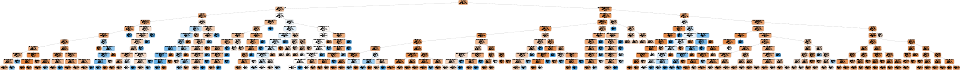

In [10]:
from sklearn.tree import export_graphviz
dot_data = export_graphviz(decision_tree_best,out_file=None, feature_names=vectorizer.feature_names_, class_names=["0","1"], rounded=True,filled=True,impurity=True)

import pydotplus
graph = pydotplus.graph_from_dot_data(dot_data)

graph.set_size('"10,10!"')
graph.write_png("onlineAD.png")

from IPython.core.display import Image
Image("onlineAD.png")

#### roc curve

In [11]:
y_pred = decision_tree_best.predict(X_test)
print("y_pred=",y_pred)

from sklearn.metrics import accuracy_score
print("acc=",accuracy_score(y_test,y_pred))

from sklearn.metrics import confusion_matrix
print("confus=", confusion_matrix(y_test, y_pred))

from sklearn.metrics import roc_auc_score, roc_curve
y_pred_proba = decision_tree_best.predict_proba(X_test)[:,1]
y_pred_proba

fpr,tpr, _ = roc_curve(y_test,y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)

y_pred= [0 0 0 ... 0 0 0]
acc= 0.83248
confus= [[81151  1359]
 [15393  2097]]


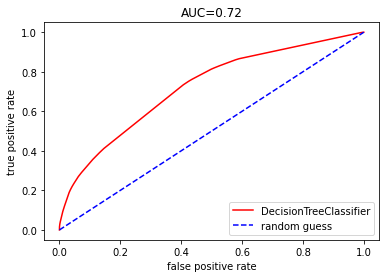

In [12]:
import matplotlib.pyplot as plt

plt.plot(fpr,tpr,"r-",label = "DecisionTreeClassifier")
plt.plot([0,1],[0,1],"b--",label = "random guess")
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.title("AUC={0:.2f}".format(auc))
plt.legend(loc="lower right")